In [1]:
import math
from numpy import linalg as LA
import numpy as np
from matplotlib import pyplot as plt 

import random
import os
from numba import njit, prange, cuda
import itertools
import sympy as sp

def decompose_spe(spe,
                  sp_para_dict,
                  para_dict,
                  condition_dict,
                  npsd,
                  sigma,
                  pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []

    expn = np.array(expn)

    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]

    expn_val_cc = []
    # expn_arg_cc = expn_imag_sort[expn_imag != 0]
    expn_val_n_cc = expn
    # expn_arg_n_cc = expn_imag_sort[expn_imag == 0]

    expn = list(expn[expn_imag_sort])
    pole, resi = PSD(npsd, 2, 1)
    beta = para_dict['beta']
    temp = 1 / beta

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 2.j * numer_get_para / np.multiply.reduce(
                    w_sp - poles_allplane[np.abs(poles_allplane - sigma * 1.J *
                                                 expn_val_n_cc[ii]) > 1e-14])
                      ).subs({w_sp: sigma * 1.j * expn_val_n_cc[ii]}) *
                     fFeim(sigma * 1.J * expn_val_n_cc[ii] / temp, pole, resi,
                           sigma))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    f = numer_get_para / np.multiply.reduce(w_sp - poles_allplane)
    f = sp.lambdify(w_sp, f)

    for inma in range(len(pole)):
        print(pole[inma])
        zomg = sigma * 1.J * pole[inma] * temp
        jsum = np.sum(f(zomg))
        expn.append(pole[inma] * temp)
        etal.append(-2.J * resi[inma] * temp * jsum)
        etar.append(np.conj(etal[-1]))
        etaa.append(np.abs(etal[-1]))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


def decompose_spe_real(spe,
                       sp_para_dict,
                       para_dict,
                       condition_dict,
                       sigma,
                       pade=1):
    #get the numerator and denominator expression of spectrum
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    
    print()
    print("decompose_spe_real: numer",numer)
    print("decompose_spe_real: denom",denom)
    print()
    
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    
    #pick the pole of spectrum begin
    poles = sp.nroots(denom_get_para)
    
    print()
    print("decompose_spe_real: poles",poles)
    print("decompose_spe_real: numer_get_para",numer_get_para)
    print("decompose_spe_real: denom_get_para",denom_get_para)
    print()
    
    float(sp.re(poles[0]))

    print("decompose_spe_real: poles",poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)
    
    #pick the pole of spectrum end
    print("decompose_spe_real: expn",expn)
    print("decompose_spe_real: poles_allplane",poles_allplane)
    
    etal = []
    etar = []
    etaa = []
    expn = np.array(expn)
    
    print("decompose_spe_real: expn",expn)
    
    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]
    expn_val_cc = []
    expn_val_n_cc = expn
    expn = list(expn[expn_imag_sort])
    
    print("decompose_spe_real: expn_val_n_cc",expn_val_n_cc)
    
    for ii in range(len(expn_val_n_cc)):
        tmp1 = complex(
                sp.N((sigma * 1.j * numer_get_para /
                      np.multiply.reduce(w_sp - poles_allplane[np.abs(
                          poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])).subs(
                              {w_sp: sigma * 1.j * expn_val_n_cc[ii]})))
        etal.append(tmp1)
        
        print(np.abs(poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14)
        print(poles_allplane[np.abs(poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])
        tmp2 = np.multiply.reduce(sigma * 1.j * expn_val_n_cc[ii] - poles_allplane[np.abs(
                          poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])
        print(tmp2)
        print((sigma * 1.j * numer_get_para / tmp2))
        print("decompose_spe_real: tmp1",tmp1)
        
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


def convert(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError


def fFeim(x, pole, resi, sigma=1):
    return 1 / 2 - sigma * sum(2.0 * resi[i] * x / (x**2 + pole[i]**2)
                               for i in range(len(pole)))


def tseig(D, E):
    mat = np.diag(E, -1) + np.diag(D, 0) + np.diag(E, 1)
    return -np.sort(-np.linalg.eigvalsh(mat))


def MSD(N, BoseFermi=2):
    if BoseFermi == 1:
        pole = np.array([2 * (i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi
    elif BoseFermi == 2:
        pole = np.array([(2 * i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi


def PSD(N, BoseFermi=2, pade=0):
    if N < 0 or BoseFermi < 1 or BoseFermi > 2 or pade < 0 or pade > 3:
        raise ValueError("N or BoseFermi or pade has wrong value!")

    if pade == 0:
        return MSD(N, BoseFermi)
    elif pade == 1 or pade == 2:
        pole, resi = [], []
        if N > 0:
            M = 2 * N + pade // 2
            temp = 3.0 if BoseFermi == 1 else 1.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            pole = 2.0 / tseig(diag, doff)[:N]
            pol2 = np.array([x * x for x in pole])
            M -= 1
            temp = 5.0 if BoseFermi == 1 else 3.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            M //= 2
            eig2 = np.power(2.0 / tseig(diag, doff)[:M], 2)
            print(eig2)

            scaling = 0.0
            if BoseFermi == 1:
                scaling = N*(2.0*N+3.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+3.0))
            elif BoseFermi == 2:
                scaling = N*(2.0*N+1.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+1.0))
            resi = np.zeros(N, dtype=float)
            for j in range(N):
                if pade == 2:
                    temp = 0.5 * scaling * (eig2[j] - pol2[j])
                elif pade == 1:
                    if j == N - 1:
                        temp = 0.5 * scaling
                    else:
                        temp = 0.5*scaling * \
                            (eig2[j]-pol2[j])/(pol2[N-1]-pol2[j])
                for k in range(M):
                    temp *= (eig2[k]-pol2[j]) / \
                        (pol2[k]-pol2[j]) if k != j else 1.0
                resi[j] = temp
        rn, tn = 0.0, 0.0
        if BoseFermi == 1 and pade == 2:
            rn = 1.0 / (4.0 * (N + 1.0) * (2.0 * N + 3.0))
        return pole, resi
    elif pade == 3:
        Np1 = N + 1
        temp = 3.0 if BoseFermi == 1 else 1.0
        d = np.empty(2 * Np1, dtype=float)
        d[0] = 0.25 / temp
        d[-1] = -4.0 * (N + 1.0) * (N + 1.0) * (temp + 2 * N) * (
            temp + 2 * N) * (temp + 4 * N + 2.0)
        for i in range(1, Np1):
            d[2*i-1] = -4.0*i*i*(temp+2.0*i-2.0) * \
                (temp+2.0*i-2.0)*(temp+4.0*i-2.0)
            d[2 * i] = -0.25 * (temp + 4.0 * i) / i / (i + 1) / (
                temp + 2.0 * i - 2.0) / (temp + 2.0 * i)
        sumd2 = np.empty(Np1, dtype=float)
        sumd2[0] = d[1]
        for i in range(1, Np1):
            sumd2[i] = sumd2[i - 1] + d[2 * i + 1]
        tn = 0.25 / sumd2[-1]
        rn = sum(d[2 * i] * (4.0 * tn *
                             (sumd2[-1] - sumd2[i - 1]))**2 if i > 0 else d[2 *
                                                                            i]
                 for i in range(Np1))
        M = 2 * N + 1
        diag = np.zeros(M, dtype=float)
        doff = np.array(
            [1.0 / math.sqrt(d[i + 1] * d[i + 2]) for i in range(M - 1)])
        pole = 2.0 / tseig(diag, doff)[:N]
        resi = np.zeros(N, dtype=float)
        for j in range(N):
            scaling = pole[j] * pole[j]
            r0, t1 = 0.0, 0.25 / d[1]
            eta0, eta1, eta2 = 0.0, 0.5, 0.0
            for i in range(Np1):
                r1 = t1 if (i == j
                            or i == N) else t1 / (pole[i] * pole[i] - scaling)
                r2 = 2.0*math.sqrt(abs(r1)) if r1 > 0 else - \
                    2.0*math.sqrt(abs(r1))
                r1 = 2.0 * math.sqrt(abs(r1))
                eta2 = d[2 * i] * r1 * eta1 - 0.25 * r1 * r0 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                eta2 = d[2 * i +
                         1] * r2 * eta1 - 0.25 * r2 * r1 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                r0 = r2
                if i != N:
                    t1 = sumd2[i] / sumd2[i + 1]
            resi[j] = eta2
        return pole, resi


# 
# in this script, we can decompose any given spectrum, but the sympy format is must been given
# do u like haskell?
# sympy[spe(def by sympy)], dict[sp_para_dict], dict[para_dict], dict[npsd],
# dict[pade] >> np.array[etal], np.array[etar],np.array[etaa], np.array[expn]



@njit()
def fit_J(w, res, expn, etal, sigma):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] + sigma * 1.j * w)
        print("i",i)
        print("fun", res[1000], "eta", etal[i], "rate", expn[i], "omega", w[1000])
        print("(expn[i] + sigma * 1.j * w)[0]", (expn[i] + sigma * 1.j * w[1000]))


def fit_t(t, res, expnt, etalt):
    for i in range(len(etalt)):
        res += etalt[i] * np.exp(-expnt[i] * t)
        print("i",i,"fun", res[99*3].imag)
        print("eta", etalt[i], "rate", expnt[i], "t", t[99*3])
        print("etal[i] * np.exp(-expn[i] * t)[99]", etalt[i] * np.exp(-expnt[i] * t[99*3]))
    return res


def fit_t_d1(t, res, expn, etal):
    for i in range(len(etal)):
        res += -expn[i] * etal[i] * np.exp(-expn[i] * t)
    return res


def INDEX3(i, j, k, mum):
    return mum * mum * i + mum * j + k


def fit_prony(phixx, n, error):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = len(vs[vs > error]) + 1
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        print(i)
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new


def fit_prony_n(phixx, n, n_choose):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = n_choose
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new

[10.0 - 2.0*I, 10.0 + 2.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775187e+03 3.94785558e+03 4.77818444e+03 5.71808109e+03
 6.94761306e+03 8.86267552e+03 1.21210495e+04 1.82005592e+04
 3.14112317e+04 6.92360915e+04 2.73607309e+05]
3.141592653589795
9.42477796076937
15.707963267948966
21.991148575128584
28.27433388230812
34.5575191894877
40.84070449666735
47.123889803851
53.40707512267524
59.690267730095854
65.97463939836028
72.30981839851239
79.22163897259144
88.24769969102927
101.30419434924487
121.03608235209411
152.952636490974
211.47247294906302
349.59500590291066
1044.578518259254
[-1.0*I, 1.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775187e+03 3.94785558e+03 4.77818444e+03 5.71808109e+03
 6.94761306e+03 8.86267552e+03 1.21210495e+04 1.82005592e+04
 3.14112317e+04 6.92360915e+04 2.73607309e+05]
3.141592653

<ipython-input-2-892ff72add5f>:60: RuntimeWarning: overflow encountered in exp
  plt.plot(w, (phixx / (1 + np.exp(beta * (w - mu_x))))/max(phixx / (1 + np.exp(beta * (w - mu_x)))),
<ipython-input-2-892ff72add5f>:64: RuntimeWarning: overflow encountered in exp
  plt.plot(w, (phixx / (1 + np.exp(beta * (w - mu_x)))) -


{21: array([ 2.        +10.j,  0.06283185 +0.j,  0.18849556 +0.j,
         0.31415927 +0.j,  0.43982297 +0.j,  0.56548668 +0.j,
         0.69115038 +0.j,  0.81681409 +0.j,  0.9424778  +0.j,
         1.0681415  +0.j,  1.19380535 +0.j,  1.31949279 +0.j,
         1.44619637 +0.j,  1.58443278 +0.j,  1.76495399 +0.j,
         2.02608389 +0.j,  2.42072165 +0.j,  3.05905273 +0.j,
         4.22944946 +0.j,  6.99190012 +0.j, 20.89157037 +0.j])}

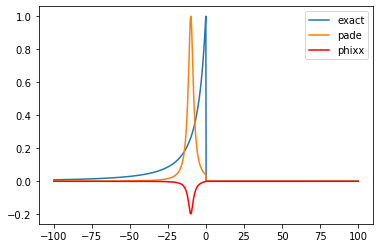

In [2]:
etal_pade_d = {}
expn_pade_d = {}

for npsd in [20]: #4, 9, 14, 512
    nmod = 4
    lams1 = 0.2   
    lams2 = 1
    gams1 = 2.0
    gams2 = 1
    omgs1 = 10.0
    omgs2 = 0
    temp = 0.02
    npfs = 6
    beta = int(1 / temp)  # in 298K
    # eta = 1.0
    mu_x = 0

    w_sp, lams1_sp, gams1_sp, omgs1_sp, gams2_sp, lams2_sp, omgs2_sp, beta_sp = sp.symbols(
        r"\omega , \lambda_1, \gamma_1, \Omega_1, \lambda_2, \gamma_2, \Omega_2, \beta",
        real=True)

    phixx_sp = lams1_sp * gams1_sp**2 / ((w_sp - omgs1_sp)**2 + gams1_sp**2)
    phixy_sp = 0
    phiyy_sp = lams2_sp * gams2_sp**2 / ((w_sp - omgs2_sp)**2 + gams2_sp**2)


    sp_para_dict = {
        lams1_sp: lams1,
        lams2_sp: lams2,
        gams1_sp: gams1,
        gams2_sp: gams2,
        omgs1_sp: omgs1,
        omgs2_sp: omgs2
    }

    condition_dict = {}
    para_dict1 = {'beta': beta}
    para_dict2 = {'beta': beta}

    etal_pade1, etar_pade1, etaa_pade1, expn_pade1 = decompose_spe(
        phixx_sp, sp_para_dict, para_dict1, condition_dict, npsd, -1)
    etal_pade2, etar_pade2, etaa_pade2, expn_pade2 = decompose_spe(
        phiyy_sp, sp_para_dict, para_dict2, condition_dict, npsd, 1)
    npsd = npsd + 1

    n_spe = 1

    len_ = 2000 + 1
    spe_wid = 100
    w = np.linspace(-spe_wid, spe_wid, len_)
    res_w = np.zeros(len(w), dtype=complex)

    phixx = lams1 * gams1**2 / (((w - mu_x) - omgs1)**2 + gams1**2)
    phixy = 0 * w
    phiyy = lams2 * gams2**2 / (((w - mu_x) - omgs2)**2 + gams2**2)

    fit_J(w, res_w, expn_pade1, etal_pade1, 1)
    
    
    plt.plot(w, (phixx / (1 + np.exp(beta * (w - mu_x))))/max(phixx / (1 + np.exp(beta * (w - mu_x)))),
             label='exact')
    plt.plot(w, res_w.real/ max(res_w.real), 
             label='pade')
    plt.plot(w, (phixx / (1 + np.exp(beta * (w - mu_x)))) -
             res_w.real,
             'r',
             label='phixx')

    plt.legend(loc='best')
    
    etal_pade_d[npsd] = etal_pade1
    expn_pade_d[npsd] = expn_pade1
# plt.savefig('spe.pdf')
# plt.clf()
expn_pade_d

i 0 fun 3.2303600902712844e-08
eta (0.39976936905824767+0.000699588946247319j) rate (2+10j) t 7.919999999999999
etal[i] * np.exp(-expn[i] * t)[99] (-4.175759661895528e-08+3.2303600902712844e-08j)
i 1 fun -0.0001870154528906429
eta (-3.7176005935858856e-06-0.0003076590664867763j) rate (0.0628318530717959+0j) t 7.919999999999999
etal[i] * np.exp(-expn[i] * t)[99] (-2.260192941824993e-06-0.0001870477564915456j)
i 2 fun -0.0002560939237351597
eta (-1.1146551728281485e-05-0.0003073932725957546j) rate (0.1884955592153874+0j) t 7.919999999999999
etal[i] * np.exp(-expn[i] * t)[99] (-2.50489134676536e-06-6.907847084451682e-05j)
i 3 fun -0.00028158320657787196
eta (-1.85567774417002e-05-0.00030686240802266153j) rate (0.3141592653589793+0j) t 7.919999999999999
etal[i] * np.exp(-expn[i] * t)[99] (-1.5414040185262056e-06-2.548928284271225e-05j)
i 4 fun -0.0002909803813551853
eta (-2.593587640344867e-05-0.0003060679153136191j) rate (0.43982297150257166+0j) t 7.919999999999999
etal[i] * np.exp(-expn[

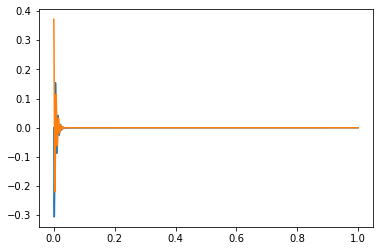

2.3406327706859553
error of decompose 9.687819096590102e-13
len of gamma 10


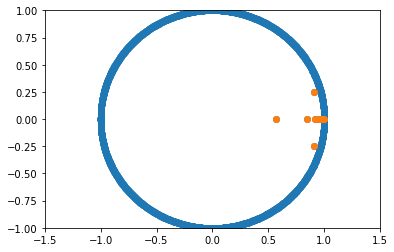

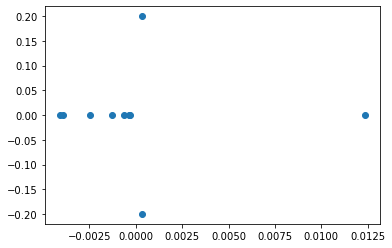

In [3]:
n = 1500
scale = 80
n_gamma = 10

n_sample = n + 1
t = np.linspace(0, 1, 2 * n + 1)
res_t = np.zeros(len(t), dtype=complex)
fit_t(scale * t, res_t, expn_pade1, etal_pade1)
plt.plot(t, np.imag(res_t))
plt.plot(t, np.real(res_t))
plt.show()

h = np.imag(res_t)
H = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H[i, :] = h[i:n_sample + i]
sing_vs, Q = LA.eigh(H)
phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
Qp = np.dot(Q, phase_mat)
sort_array = np.argsort(vs)[::-1]
vs = vs[sort_array]
Qp = (Qp[:, sort_array])
print(vs[0])
print(
    "error of decompose",
    np.sum(np.abs(H -
                  np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))

print("len of gamma", n_gamma)
gamma = np.roots(Qp[:,n_gamma][::-1])
gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
t_new = 2*n*np.log(gamma_new)
plt.scatter(np.real(gamma),np.imag(gamma))
plt.scatter(np.real(gamma_new),np.imag(gamma_new))
plt.xlim(-1.5,1.5)
plt.ylim(-1,1)
plt.show()
gamma_m = np.zeros((n_sample*2-1, n_gamma), dtype=complex)
for i in range(n_gamma):
    for j in range(n_sample*2-1):
        gamma_m[j,i] = gamma_new[i]**j
omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)), np.dot(np.transpose(gamma_m), np.transpose(h)))
plt.scatter(np.real(omega_new),np.imag(omega_new))
plt.show()

rate [20.93490668-0.00000000e+00j  6.32553238-4.39397579e-16j
  3.09239485-2.59974511e-14j  1.99999737+9.99999684e+00j
  1.99999737-9.99999684e+00j  1.5361008 +8.32584146e-14j
  0.76102967-9.81349095e-14j  0.38199183-2.35680341e-14j
  0.19313641+7.09812038e-14j  0.06285404+1.28417946e-14j]
omega_new [ 0.01232705-1.11022302e-14j -0.00390668+8.79296636e-14j
 -0.00407257-5.50670620e-14j  0.00034902-1.99884255e-01j
  0.00034902+1.99884255e-01j -0.00247635+3.73034936e-14j
 -0.00128346-1.57651669e-14j -0.00062881+7.32747196e-15j
 -0.00034899-2.16493490e-15j -0.00030807+9.88792381e-17j]


decompose_spe_real: numer \gamma_1**2*\lambda_1
decompose_spe_real: denom \Omega_1**2 - 2*\Omega_1*\omega + \gamma_1**2 + \omega**2


decompose_spe_real: poles [10.0 - 2.0*I, 10.0 + 2.0*I]
decompose_spe_real: numer_get_para 0.800000000000000
decompose_spe_real: denom_get_para \omega**2 - 20.0*\omega + 104.0

decompose_spe_real: poles [10.0 - 2.0*I, 10.0 + 2.0*I]
decompose_spe_real: expn [(2-10j)]
decompose_s

<ipython-input-4-c14941e5ccb5>:112: RuntimeWarning: overflow encountered in exp
  (w - mu_x) - omgs1)**2 + gams1**2) / (1 + np.exp(beta * (w - mu_x)))


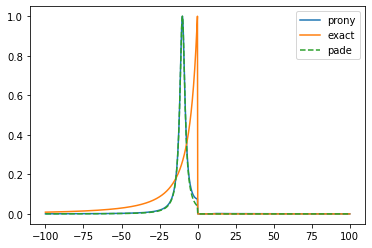


 0.0 
 psd 0.019258386717323377 
 exact 0.5130975469296786 
 prony 0.03813915170874067

pade:time evolution
rate_pade
 [ 2.        +10.j  0.06283185 +0.j  0.18849556 +0.j  0.31415927 +0.j
  0.43982297 +0.j  0.56548668 +0.j  0.69115038 +0.j  0.81681409 +0.j
  0.9424778  +0.j  1.0681415  +0.j  1.19380535 +0.j  1.31949279 +0.j
  1.44619637 +0.j  1.58443278 +0.j  1.76495399 +0.j  2.02608389 +0.j
  2.42072165 +0.j  3.05905273 +0.j  4.22944946 +0.j  6.99190012 +0.j
 20.89157037 +0.j]
eta_pade
 [ 3.99769369e-01+0.00069959j -3.71760059e-06-0.00030766j
 -1.11465517e-05-0.00030739j -1.85567774e-05-0.00030686j
 -2.59358764e-05-0.00030607j -3.32715701e-05-0.00030501j
 -4.05517509e-05-0.0003037j  -4.77645285e-05-0.00030213j
 -5.48982758e-05-0.00030031j -6.19416726e-05-0.00029824j
 -6.88842127e-05-0.00029594j -7.57791457e-05-0.00029364j
 -8.46765871e-05-0.00029834j -1.09265152e-04-0.00034994j
 -1.68527729e-04-0.00048165j -2.80808433e-04-0.00069226j
 -5.04323173e-04-0.00102231j -1.01661504e-03-0.001

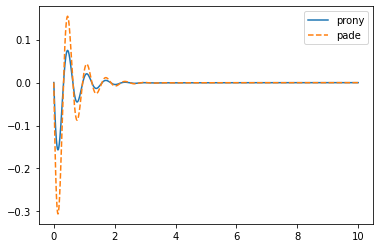

In [4]:
def decompose_spe_real(spe,
                       sp_para_dict,
                       para_dict,
                       condition_dict,
                       sigma,
                       pade=1):
    #get the numerator and denominator expression of spectrum
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    
    print()
    print("decompose_spe_real: numer",numer)
    print("decompose_spe_real: denom",denom)
    print()
    
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    
    #pick the pole of spectrum begin
    poles = sp.nroots(denom_get_para)
    
    print()
    print("decompose_spe_real: poles",poles)
    print("decompose_spe_real: numer_get_para",numer_get_para)
    print("decompose_spe_real: denom_get_para",denom_get_para)
    print()
    
    float(sp.re(poles[0]))

    print("decompose_spe_real: poles",poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)
    
    #pick the pole of spectrum end
    print("decompose_spe_real: expn",expn)
    print("decompose_spe_real: poles_allplane",poles_allplane)
    
    etal = []
    etar = []
    etaa = []
    expn = np.array(expn)
    
    print("decompose_spe_real: expn",expn)
    
    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]
    expn_val_cc = []
    expn_val_n_cc = expn
    expn = list(expn[expn_imag_sort])
    
    print("decompose_spe_real: expn_val_n_cc",expn_val_n_cc)
    
    for ii in range(len(expn_val_n_cc)):
        tmp1 = complex(
                sp.N((sigma * 1.j * numer_get_para /
                      np.multiply.reduce(w_sp - poles_allplane[np.abs(
                          poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])).subs(
                              {w_sp: sigma * 1.j * expn_val_n_cc[ii]})))
        etal.append(tmp1)
        
        print(np.abs(poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14)
        print(poles_allplane[np.abs(poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])
        tmp2 = np.multiply.reduce(sigma * 1.j * expn_val_n_cc[ii] - poles_allplane[np.abs(
                          poles_allplane -sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])
        print("decompose_spe_real: tmp2",tmp2)
        print("decompose_spe_real: numer_get_para",numer_get_para)
        print((sigma * 1.j * numer_get_para / tmp2))
        print("decompose_spe_real: tmp1",tmp1)
        
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


etal1 = 1.j * omega_new
etar1 = np.conjugate(1.j * omega_new)
etaa1 = np.abs(omega_new)
expn1 = -t_new / scale

print("rate",expn1)
print("omega_new", omega_new)

print()

etal_real1, etar_real1, etaa_real1, expn_real1 = decompose_spe_real(
    phixx_sp, sp_para_dict, para_dict1, condition_dict, 1)

etal1 = np.append(etal1, etal_real1)
etar1 = np.append(etar1, etar_real1)
etaa1 = np.append(etaa1, etaa_real1)
expn1 = np.append(expn1, expn_real1)

expn_prony1 = expn1
etal_prony1 = etal1

len_ = 2000 + 1
spe_wid = 100
w = np.linspace(-spe_wid, spe_wid, len_)
phixx = lams1 * gams1**2 / ((
    (w - mu_x) - omgs1)**2 + gams1**2) / (1 + np.exp(beta * (w - mu_x)))
res_J1 = np.zeros(len(w), dtype=complex)
res_J1_10 = np.zeros(len(w), dtype=complex)
res_t1 = np.zeros(len(t), dtype=complex)
fit_J(w, res_J1, expn1, etal1, 1)
print()
fit_J(w, res_J1_10, expn_prony1, etal_prony1, 1)
plt.plot(w, res_J1_10.real/max(np.abs(res_J1_10.real)), label='prony')
plt.plot(w, phixx.real/max(np.abs(phixx.real)), label='exact')
plt.plot(w, res_w.real/ max(res_w.real), label='pade', linestyle='--')
plt.legend(loc='best')
plt.show()

print()
x = 1000
a = max(np.abs(res_w.real))
b = max(np.abs(phixx.real))
c = max(np.abs(res_J1_10.real))
print('',w[x],'\n psd',(res_w[x]/a).real,'\n exact',phixx[x]/b,'\n prony',(res_J1_10[x]/c).real)

tt = np.linspace(0, 10, 3001)
print()
print("pade:time evolution")
print("rate_pade\n",expn_pade1)
print("eta_pade\n",etal_pade1)

res_t = np.zeros(len(tt), dtype=complex)
fit_t(tt, res_t, expn_pade1, etal_pade1)
print()
print("prony:time evolution")

print("rate_prony\n",expn_prony1)
print("eta_prony\n",etal_prony1)
fit_t(tt, res_t1, expn_prony1, etal_prony1)

plt.plot(tt, res_t1.imag, label='prony')
plt.plot(tt, res_t.imag, label='pade', linestyle='--')
plt.legend(loc='best')
plt.show()

In [5]:
fermi_path = "../PFS/fermi-1-1/f-{}-comp/"
for npfs, beta in itertools.product([10], [100]):
    if os.path.exists((fermi_path + "etal1_{}").format(beta, npfs-1)):
        etal_prony1 = np.loadtxt((fermi_path + "etal1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn1_{}").format(beta, npfs-1)):
        expn_prony1 = np.loadtxt((fermi_path + "expn1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "etal2_{}").format(beta, npfs-1)):
        etal_prony2 = np.loadtxt((fermi_path + "etal2_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn2_{}").format(beta, npfs-1)):
        expn_prony2 = np.loadtxt((fermi_path + "expn2_{}").format(beta, npfs-1), dtype=complex)
        
# len_ = 10000
# spe_wid = 6

# w_origin = np.array([
#     -(np.linspace(0, spe_wid, len_))[::-1] - 0.5,
#     np.linspace(-0.5, 0.5, len_),
#     np.linspace(0, spe_wid, len_) + 0.5
# ]).flatten()
# w = np.array([
#     -10**(np.linspace(0, spe_wid, len_))[::-1],
#     np.linspace(-1, 1, len_), 10**np.linspace(0, spe_wid, len_)
# ]).flatten()

# w_sp, lamd_sp, gams_sp, beta_sp = sp.symbols(
#     r"\omega , \lambda, \gamma, \beta", real=True)

len_ = 100000
spe_wid = 20
w = np.linspace(-spe_wid, spe_wid, len_)
phixx = lams1 * gams1**2 / ((
    (w - mu_x) - omgs1)**2 + gams1**2) / (1 + np.exp(beta * (w - mu_x)))
res_J1 = np.zeros(len(w), dtype=complex)
res_J1_10 = np.zeros(len(w), dtype=complex)
fit_J(w, res_J1, expn1, etal1, 1)
fit_J(w, res_J1_10, expn_prony1, etal_prony1, 1)
res_J1_pade_d = {}
for npsd in [5, 10, 15]:
    etal_pade1 = etal_pade_d[npsd]
    expn_pade1 = expn_pade_d[npsd]
    res_J1_pade = np.zeros(len(w), dtype=complex)
    fit_J(w, res_J1_pade, expn_pade1, etal_pade1, 1)
    res_J1_pade_d[npsd] = res_J1_pade

i 0
fun (-0.00029377575624628144+0.00031378414777701936j) eta (1.1102230246251565e-14+0.01232704549805419j) rate (20.934906677981473-0j) omega -19.59999599996
(expn[i] + sigma * 1.j * w)[0] (20.934906677981473-19.59999599996j)
i 1
fun (-0.00011325728251630057+0.00025552518427943036j) eta (-8.79296635503124e-14-0.003906680323268574j) rate (6.325532383653128-4.393975793220451e-16j) omega -19.59999599996
(expn[i] + sigma * 1.j * w)[0] (6.325532383653128-19.59999599996j)
i 2
fun (8.948040485541169e-05+0.0002235381889624054j) eta (5.5067062021407764e-14-0.004072574281110519j) rate (3.092394849952173-2.599745114639053e-14j) omega -19.59999599996
(expn[i] + sigma * 1.j * w)[0] (3.092394849952173-19.599995999960026j)
i 3
fun (0.004211958482856827+0.020185967982884356j) eta (0.1998842545505064+0.00034902097969080614j) rate (1.9999973688249835+9.999996840548347j) omega -19.59999599996
(expn[i] + sigma * 1.j * w)[0] (1.9999973688249835-9.599999159411654j)
i 4
fun (0.003746021375902335+0.013464602

<ipython-input-5-cf162788addd>:32: RuntimeWarning: overflow encountered in exp
  (w - mu_x) - omgs1)**2 + gams1**2) / (1 + np.exp(beta * (w - mu_x)))


KeyError: 5

In [ ]:
from matplotlib import rc
from matplotlib import rcParams
import dill

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)
plt.rc('font', family='serif')
# params = {
#     'text.latex.preamble': [
#         r'\usepackage{amsmath}\usepackage[dvips]{graphicx}\usepackage{xfrac}\usepackage{scalerel}\usepackage{siunitx}\usepackage{bm}'
#     ]
# }
rcParams['axes.linewidth'] = 2
rcParams['lines.linewidth'] = 1.5
rcParams['xtick.major.width'] = 3
rcParams['xtick.minor.size'] = 5
rcParams['xtick.major.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['ytick.major.size'] = 5
rcParams['xtick.minor.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.minor.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
params = {}
plt.rcParams.update(params)
plt.rcParams['figure.figsize'] = [5, 6]
fontsize = 12
sca_size = 2
plt.rc('font', size=fontsize)  #controls default text size
plt.rc('axes', titlesize=fontsize)  #fontsize of the title
plt.rc('axes', labelsize=fontsize)  #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)  #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize)  #fontsize of the y tick labels
plt.rc('legend', fontsize=10)  #fontsize of the legend

f, axes = plt.subplots(3, 2, sharey=False, sharex=False)

begin_y = 0.075
end_y = 0.99
int_y = 0.1
begin_x = 0.1
end_x = 0.99
int_x = 0.15
end_x += int_x
end_y += int_y

shapexy = np.shape(axes)
inter_x = np.linspace(begin_x, end_x, shapexy[1] + 1)
inter_y = np.linspace(begin_y, end_y, shapexy[0] + 1)

delta_x = inter_x[1] - inter_x[0] - int_x
delta_y = inter_y[1] - inter_y[0] - int_y

text_l = [[r'\textbf{(c)}', r'\textbf{(d)}'],
          [r'\textbf{(a)}', r'\textbf{(b)}']]
for i in range(shapexy[0]):
    for j in range(shapexy[1]):
        axes[i][j].set_position([
            inter_x[j], inter_y[i], inter_x[j + 1] - inter_x[j] - int_x,
            inter_y[i + 1] - inter_y[i] - int_y
        ])
        axes[i][j].xaxis.set_tick_params(direction='in',
                                         which='both',
                                         bottom=True,
                                         top=True)
        axes[i][j].yaxis.set_tick_params(direction='in',
                                         which='both',
                                         left=True,
                                         right=True)
fontsize += 2
axes[1][0].text(0.825,
                0.875,
                text_l[0][0],
                fontsize=fontsize,
                transform=axes[1][1].transAxes)
axes[2][0].text(0.825,
                0.825,
                text_l[1][0],
                fontsize=fontsize,
                transform=axes[2][0].transAxes)
axes[2][1].text(0.825,
                0.825,
                text_l[1][1],
                fontsize=fontsize,
                transform=axes[2][1].transAxes)
axes[0][0].text(0.825,
                0.75,
                r'\textbf{(d)}',
                fontsize=fontsize,
                transform=axes[0][1].transAxes)

axes[1][0].set_position([
    inter_x[0], inter_y[1] - 0.025, inter_x[2] - inter_x[0] - int_x,
    inter_y[2] - inter_y[1] - 0.05
])

axes[1][0].plot(10 * w, ((res_J1.real)), 'k', label='PFD: K = 5')
axes[1][0].plot(10 * w, ((res_J1_10.real)), 'g', label='PFD: K = 10')
axes[1][0].plot(10 * w, ((res_J1_pade_d[5].real)), 'k--', label=r'PSD: K = 5')
axes[1][0].plot(10 * w, ((res_J1_pade_d[10].real)), 'g--', label=r'PSD: K = 10')
axes[1][0].plot(10 * w, ((res_J1_pade_d[15].real)), 'b--', label=r'PSD: K = 15')
axes[1][0].plot(10 * w, ((phixx.real)), 'r:', label=r'Exact')

axes[1][0].set_xlim(-110, 160)
axes[1][0].legend(loc="upper left",
                  framealpha=0.0).get_frame().set_linewidth(0.0)
axes[1][0].set_ylim(-0.125, 1.125)
axes[1][0].set_yticks([0, 1])
axes[1][0].set_yticklabels(['$0$', '$1$'])
axes[1][0].set_xlabel(r'$\omega$ (in $\Delta$)')
axes[1][0].set_ylabel(r'$C_{\mbox{\small B}}(\omega)$')
axes[1][0].yaxis.set_label_coords(-0.0625, 0.5)
axes[1][0].xaxis.set_label_coords(0.5, -0.1)

axes_p = f.add_subplot(1,1,1)
axes_p.set_position([
    inter_x[1] - 0.1 + 0.05, inter_y[1] + 0.075,
    inter_x[2] - inter_x[1] - int_x - 0.05,
    inter_y[2] - inter_y[1] - int_y - 0.1
])
axes_p.xaxis.set_tick_params(direction='in',
                                 which='both',
                                 bottom=True,
                                 top=True)
axes_p.yaxis.set_tick_params(direction='in',
                                 which='both',
                                 left=True,
                                 right=True)
axes_p.plot(10 * w, (res_J1.real), 'k')
axes_p.plot(10 * w, (res_J1_10.real), 'g')
axes_p.plot(10 * w, (res_J1_pade_d[5].real), 'k--')
axes_p.plot(10 * w, (res_J1_pade_d[10].real), 'g--')
axes_p.plot(10 * w, (res_J1_pade_d[15].real), 'b--')
axes_p.plot(10 * w, np.abs(phixx.real), 'r:')
axes_p.set_xlim(-10, 110)
axes_p.set_ylim(-0.005, 0.0125)
axes_p.set_yticks([0, 0.01])
axes_p.set_yticklabels(['$0$', '$0.01$'])

# 
x = np.linspace(0.5, 1, 1000)
y = np.sqrt(1 - x * x)
axes[2][1].plot(x, y, 'k')
axes[2][1].plot(x, -y, 'k')
axes[2][1].scatter(np.real(gamma_new),
                   np.imag(gamma_new),
                   marker='x',
                   color='r',
                   s=15 * sca_size)
axes[2][1].set_xlim(0.89, 1.06)
axes[2][1].set_ylim(-0.23, 0.23)
axes[2][1].set_yticks([-0.2, 0, 0.2])
axes[2][1].set_yticklabels([-0.2, 0, 0.2])
axes[2][1].set_xticks([0.9, 0.95, 1, 1.05])
axes[2][1].set_xticklabels([0.9, 0.95, 1, 1.05])

axes[2][0].plot(np.log10(vs), 'k')
axes[2][0].set_xlabel(r'$N$')
axes[2][0].set_ylabel(r'ln $(|\sigma_{\mbox{\tiny N}}|)$')
axes[2][0].set_ylim(-34, 4)
axes[2][0].set_xlim(-1000, 16000)
axes[2][0].set_yticks([0, -10, -20, -30])
axes[2][0].set_yticklabels(
    [r'$0$', r'-$10$', r'-$20$', r'-$30$'])
axes[2][0].set_xticks([0, 5000, 10000, 15000])
axes[2][0].set_xticklabels([0, 5000, 10000, 15000])
axes[2][1].set_xlabel('Re $\phi$')
axes[2][1].set_ylabel('Im $\phi$')

axes[2][1].yaxis.set_label_coords(-0.15, 0.5)
axes[2][0].yaxis.set_label_coords(-0.15, 0.5)

axes[2][1].xaxis.set_label_coords(0.5, -0.15)
axes[2][0].xaxis.set_label_coords(0.5, -0.15)

axes[0][0].set_position([
    inter_x[0], inter_y[0], inter_x[2] - inter_x[0] - int_x,
    inter_y[1] - inter_y[0] - int_y
])
axes[0][0].set_xlim(-18, 37.5)
axes[0][0].set_ylim(-0.125, 1.125)
axes[0][0].set_yticks([0, 1])
axes[0][0].set_ylabel(r'$C_{\mbox{\small B}}(\omega)$')
axes[0][0].yaxis.set_label_coords(-0.0625, 0.5)
axes[1][0].xaxis.set_label_coords(0.5, -0.1)

f.delaxes(axes[1][1])
f.delaxes(axes[0][1])

plt.savefig("fig1.eps", format='eps')
plt.savefig("fig1.pdf")

In [ ]:
def arma_print(ndarray):

#     shape = ndarray.shape
#     dimen = len(shape)

#     if dimen == 1:

#         if issubclass(type(ndarray[0]), np.int_):
#             print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1))
#             for row in ndarray:
#                 print('%d' % row)
#         elif issubclass(type(ndarray[0]), float):
#             print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1))
#             for row in ndarray:
#                 print('%.8e' % row)
#         elif issubclass(type(ndarray[0]), complex):
#             print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1))
#             for row in ndarray:
#                 print('(%.8e,%-.8e)' % (row.real, row.imag))

#     elif dimen == 2:

#         if issubclass(type(ndarray[0, 0]), np.int_):
#             print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]))
#             for row in ndarray:
#                 print(' '.join('%d' % x for x in row))
#         elif issubclass(type(ndarray[0, 0]), float):
#             print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]))
#             for row in ndarray:
#                 print(' '.join('%.8e' % x for x in row))
#         elif issubclass(type(ndarray[0, 0]), complex):
#             print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]))
#             for row in ndarray:
#                 print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag) for x in row))

#     elif dimen == 3:

#         if issubclass(type(ndarray[0, 0, 0]), np.int_):
#             print('ARMA_CUB_TXT_IS004\n%d %d %d' %
#                   (shape[1], shape[2], shape[0]))
#             for slc in ndarray:
#                 for row in slc:
#                     print(' '.join('%d' % x for x in row))
#         elif issubclass(type(ndarray[0, 0, 0]), float):
#             print('ARMA_CUB_TXT_FN008\n%d %d %d' %
#                   (shape[1], shape[2], shape[0]))
#             for slc in ndarray:
#                 for row in slc:
#                     print(' '.join('%-.8e' % x for x in row))
#         elif issubclass(type(ndarray[0, 0, 0]), complex):
#             print('ARMA_CUB_TXT_FC016\n%d %d %d' %
#                   (shape[1], shape[2], shape[0]))
#             for slc in ndarray:
#                 for row in slc:
#                     print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
#                                    for x in row))


# def arma_write(ndarray, filename):

#     shape = ndarray.shape
#     dimen = len(shape)

#     with open(filename, 'w') as f:
#         if dimen == 1:
#             if issubclass(type(ndarray[0]), np.int_):
#                 print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1), file=f)
#                 for row in ndarray:
#                     print('%d' % row, file=f)
#             elif issubclass(type(ndarray[0]), float):
#                 print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1), file=f)
#                 for row in ndarray:
#                     print('%.8e' % row, file=f)
#             elif issubclass(type(ndarray[0]), complex):
#                 print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1), file=f)
#                 for row in ndarray:
#                     print('(%.8e,%-.8e)' % (row.real, row.imag), file=f)

#         elif dimen == 2:

#             if issubclass(type(ndarray[0, 0]), np.int_):
#                 print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]),
#                       file=f)
#                 for row in ndarray:
#                     print(' '.join('%d' % x for x in row), file=f)
#             elif issubclass(type(ndarray[0, 0]), float):
#                 print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]),
#                       file=f)
#                 for row in ndarray:
#                     print(' '.join('%.8e' % x for x in row), file=f)
#             elif issubclass(type(ndarray[0, 0]), complex):
#                 print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]),
#                       file=f)
#                 for row in ndarray:
#                     print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
#                                    for x in row),
#                           file=f)

#         elif dimen == 3:

#             if issubclass(type(ndarray[0, 0, 0]), np.int_):
#                 print('ARMA_CUB_TXT_IS004\n%d %d %d' %
#                       (shape[1], shape[2], shape[0]),
#                       file=f)
#                 for slc in ndarray:
#                     for row in slc:
#                         print(' '.join('%d' % x for x in row))
#             elif issubclass(type(ndarray[0, 0, 0]), float):
#                 print('ARMA_CUB_TXT_FN008\n%d %d %d' %
#                       (shape[1], shape[2], shape[0]),
#                       file=f)
#                 for slc in ndarray:
#                     for row in slc:
#                         print(' '.join('%-.8e' % x for x in row), file=f)
#             elif issubclass(type(ndarray[0, 0, 0]), complex):
#                 print('ARMA_CUB_TXT_FC016\n%d %d %d' %
#                       (shape[1], shape[2], shape[0]),
#                       file=f)
#                 for slc in ndarray:
#                     for row in slc:
#                         print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
#                                        for x in row),
#                               file=f)

